In [ ]:
#dataset: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset

In [ ]:
# !unzip '/content/drive/MyDrive/Project/AI/weather_dataset.zip' -d '/content/drive/MyDrive/Project/AI'

In [ ]:
pip install split-folders

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import random
import splitfolders
import cv2
import glob
import csv
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report

In [ ]:
# # Splitting dataset into train, validation, and test sets
# splitfolders.ratio("/content/drive/MyDrive/Project/AI/weather/dataset",
#                    output = "/content/drive/MyDrive/Project/AI/weather/preprocessed dataset",
#                    seed = 42,
#                    ratio = (.7, .2, .1),
#                    group_prefix = None,
#                    move = False)

In [ ]:
# pre_images_dir = '/content/drive/MyDrive/Project/AI/preprocessed dataset'

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Project/AI/weather/preprocessed dataset/train',
                                                                 label_mode="categorical",
                                                                 image_size=(224, 224),
                                                                 seed=42)
val_data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Project/AI/weather/preprocessed dataset/val',
                                                               label_mode="categorical",
                                                               image_size=(224, 224),
                                                               seed=42)
test_data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Project/AI/weather/preprocessed dataset/test',
                                                               label_mode="categorical",
                                                               image_size=(224, 224),
                                                               seed=42,
                                                               shuffle=False)

Found 4819 files belonging to 11 classes.
Found 1375 files belonging to 11 classes.
Found 698 files belonging to 11 classes.


In [ ]:
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal',input_shape=(224,224,3), seed = 42),
  preprocessing.RandomRotation(0.2, seed = 42),
  preprocessing.RandomHeight(0.2, seed = 42),
  preprocessing.RandomWidth(0.2, seed = 42),
  preprocessing.RandomZoom(0.2, seed = 42)])

In [ ]:
# Callback to save the best model based on validation accuracy during training
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project/AI/weather/Checkpoint',
                                                      save_best_only = True,
                                                      monitor = "val_accuracy")

# Callback to reduce the learning rate when the validation accuracy stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_accuracy",
                                                 factor = 0.2,
                                                 patience = 3,
                                                 min_lr = 1e-7)

# Callback to log training history to a csv file
base_csv_logger = tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/Project/AI/weather/Base Model History.csv')
ft_csv_logger = tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/Project/AI/weather/Fine-Tuned Model History.csv')

In [ ]:
base_model = tf.keras.applications.VGG16(weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False) # Load the VGG19 model without the top layer

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base_model.trainable = False#freezing
inputs = tf.keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = layers.Dense(11, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(loss = "categorical_crossentropy",
              optimizer = 'adam',
              metrics = ["accuracy"])

In [ ]:
# Training the base model
model.fit(train_data,
          epochs = 25,
          steps_per_epoch = len(train_data),
          validation_data = val_data,
          validation_steps = len(val_data),
          callbacks = [model_checkpoint, reduce_lr, base_csv_logger])

Epoch 1/25
151/151 [==============================] - 52s 266ms/step - loss: 2.5718 - accuracy: 0.4794 - val_loss: 1.3004 - val_accuracy: 0.6756 - lr: 0.0010
Epoch 2/25
151/151 [==============================] - 33s 215ms/step - loss: 0.9060 - accuracy: 0.7381 - val_loss: 0.9716 - val_accuracy: 0.7549 - lr: 0.0010
Epoch 3/25
151/151 [==============================] - 34s 217ms/step - loss: 0.6387 - accuracy: 0.8105 - val_loss: 0.8473 - val_accuracy: 0.7789 - lr: 0.0010
Epoch 4/25
151/151 [==============================] - 35s 219ms/step - loss: 0.5044 - accuracy: 0.8425 - val_loss: 0.7702 - val_accuracy: 0.7956 - lr: 0.0010
Epoch 5/25
151/151 [==============================] - 31s 197ms/step - loss: 0.4168 - accuracy: 0.8662 - val_loss: 0.7259 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 6/25
151/151 [==============================] - 29s 189ms/step - loss: 0.3497 - accuracy: 0.8923 - val_loss: 0.7174 - val_accuracy: 0.8058 - lr: 0.0010
Epoch 7/25
151/151 [==============================] 

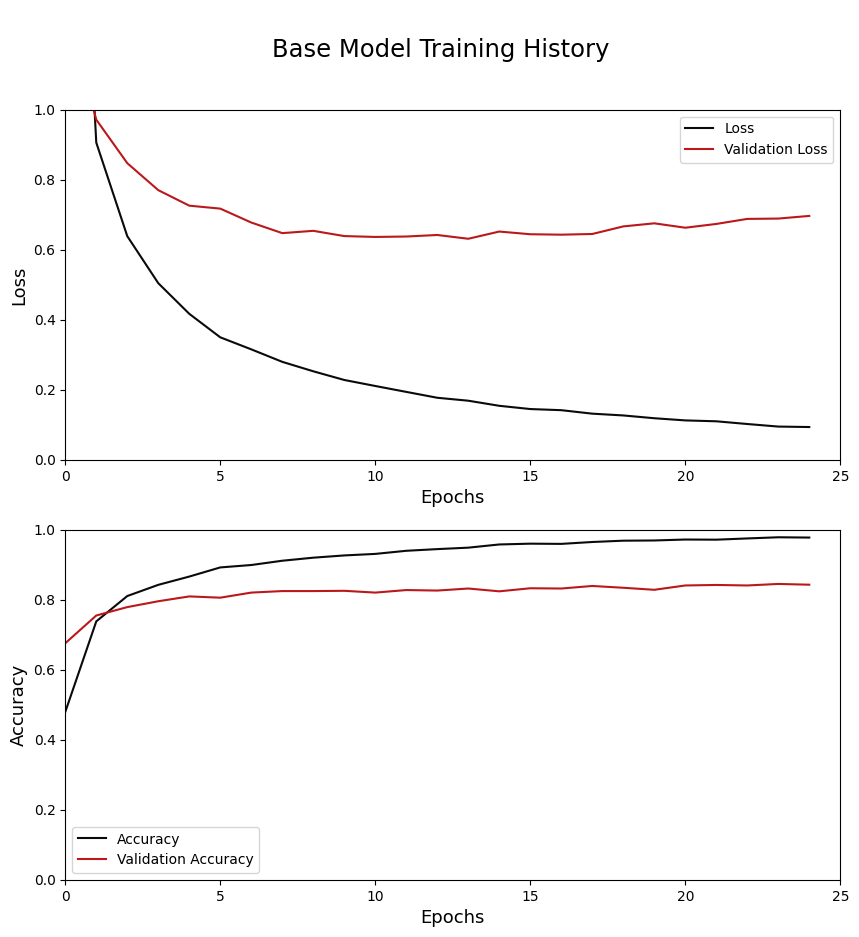

In [ ]:
# Load the base model's training history
history = pd.read_csv('/content/drive/MyDrive/Project/AI/weather/Base Model History.csv')

# Extract the values for loss, val_loss, accuracy, and val_accuracy
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Define number of epochs
epochs = range(len(loss))

# Plot the training history using two subplots (for loss and accuracy)
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

fig.suptitle("\nBase Model Training History", fontsize = 17.5)

ax[0].plot(epochs, loss, label = 'Loss', color = "#0B090A")
ax[0].plot(epochs, val_loss, label = 'Validation Loss', color = "#BA181B")
ax[0].set_xlim(0, 25)
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Loss', fontsize = 13)
ax[0].set_xlabel('Epochs', fontsize = 13)
ax[0].legend()

ax[1].plot(epochs, accuracy, label = 'Accuracy', color = "#0B090A")
ax[1].plot(epochs, val_accuracy, label = 'Validation Accuracy', color = "#BA181B")
ax[1].set_xlim(0, 25)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs', fontsize = 13)
ax[1].set_ylabel('Accuracy', fontsize = 13)
ax[1].legend();

Fine Tuned Model

In [ ]:
# Unfreezing the base model entirely
base_model.trainable = True

# Freezing all layers in the base model, except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Compiling the model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 2.0000e-05),
              metrics = ["accuracy"])

In [ ]:
# Training the fine-tuned model
model.fit(train_data,
          epochs = 25,
          steps_per_epoch = len(train_data),
          validation_data = val_data,
          validation_steps = len(val_data),
          callbacks = [model_checkpoint, ft_csv_logger, reduce_lr])

Epoch 1/25
151/151 [==============================] - 53s 289ms/step - loss: 0.2781 - accuracy: 0.9050 - val_loss: 0.6201 - val_accuracy: 0.8415 - lr: 2.0000e-05
Epoch 2/25
151/151 [==============================] - 44s 285ms/step - loss: 0.1043 - accuracy: 0.9670 - val_loss: 0.6201 - val_accuracy: 0.8655 - lr: 2.0000e-05
Epoch 3/25
151/151 [==============================] - 42s 272ms/step - loss: 0.0462 - accuracy: 0.9859 - val_loss: 0.6956 - val_accuracy: 0.8691 - lr: 2.0000e-05
Epoch 4/25
151/151 [==============================] - 43s 279ms/step - loss: 0.0408 - accuracy: 0.9882 - val_loss: 0.5923 - val_accuracy: 0.8822 - lr: 2.0000e-05
Epoch 5/25
151/151 [==============================] - 42s 267ms/step - loss: 0.0272 - accuracy: 0.9919 - val_loss: 0.7909 - val_accuracy: 0.8771 - lr: 2.0000e-05
Epoch 6/25
151/151 [==============================] - 40s 255ms/step - loss: 0.0673 - accuracy: 0.9797 - val_loss: 0.6409 - val_accuracy: 0.8633 - lr: 2.0000e-05
Epoch 7/25
151/151 [========

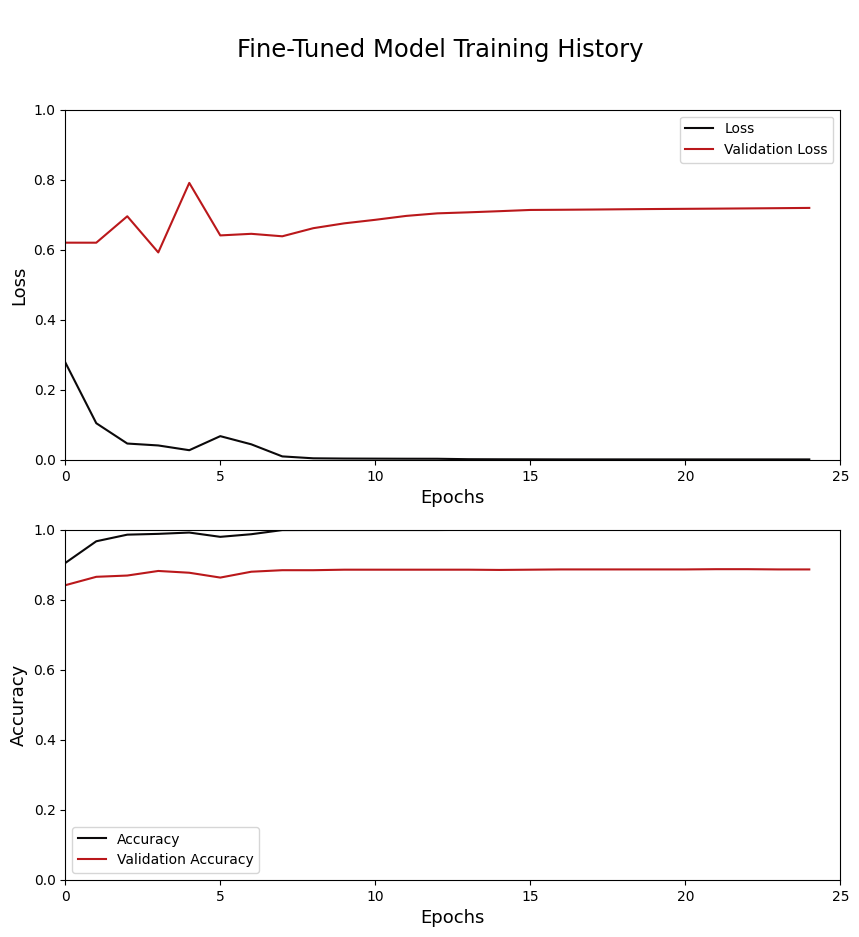

In [ ]:
# Load the fine-tuned model's training history
history = pd.read_csv('/content/drive/MyDrive/Project/AI/weather/Fine-Tuned Model History.csv')

# Extract the values for loss, val_loss, accuracy, and val_accuracy
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Define number of epochs
epochs = range(len(loss))

# Plot the training history using two subplots (for loss and accuracy)
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

fig.suptitle("\nFine-Tuned Model Training History", fontsize = 17.5)

ax[0].plot(epochs, loss, label = 'Loss', color = "#0B090A")
ax[0].plot(epochs, val_loss, label = 'Validation Loss', color = "#BA181B")
ax[0].set_xlim(0, 25)
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Loss', fontsize = 13)
ax[0].set_xlabel('Epochs', fontsize = 13)
ax[0].legend()

ax[1].plot(epochs, accuracy, label = 'Accuracy', color = "#0B090A")
ax[1].plot(epochs, val_accuracy, label = 'Validation Accuracy', color = "#BA181B")
ax[1].set_xlim(0, 25)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs', fontsize = 13)
ax[1].set_ylabel('Accuracy', fontsize = 13)
ax[1].legend();

In [ ]:
# Load the weights
model.load_weights('/content/drive/MyDrive/Project/AI/weather/Checkpoint')

In [ ]:
# Calculating the accuracy of the model on the test dataset
accuracy = model.evaluate(test_data)[1] * 100

22/22 [==============================] - 115s 5s/step - loss: 0.5489 - accuracy: 0.9011


In [ ]:
import pickle

pickle.dump(model, open('/content/drive/MyDrive/Project/AI/weather/weather_model.pkl', 'wb'))

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pickle

pickled_model = pickle.load(open('/content/drive/MyDrive/Project/AI/weather/weather_model.pkl', 'rb'))

class_names = ['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    print(image)
    preds = pickled_model.predict(image)
    return preds

In [6]:
import numpy as np

[[[[ 86.061     43.221    -20.68    ]
   [ 86.061     42.221    -19.68    ]
   [ 86.061     42.221    -19.68    ]
   ...
   [104.061     66.221     27.32    ]
   [104.061     66.221     27.32    ]
   [101.061     65.221     26.32    ]]

  [[ 86.061     43.221    -20.68    ]
   [ 86.061     42.221    -19.68    ]
   [ 86.061     42.221    -19.68    ]
   ...
   [104.061     66.221     27.32    ]
   [104.061     66.221     27.32    ]
   [101.061     65.221     26.32    ]]

  [[ 86.061     43.221    -20.68    ]
   [ 86.061     42.221    -19.68    ]
   [ 86.061     42.221    -19.68    ]
   ...
   [104.061     66.221     27.32    ]
   [104.061     66.221     27.32    ]
   [101.061     65.221     26.32    ]]

  ...

  [[ 30.060997  58.221     74.32    ]
   [ 33.060997  61.221     77.32    ]
   [ 31.060997  59.221     74.32    ]
   ...
   [ 81.061     54.221     24.32    ]
   [ 81.061     54.221     24.32    ]
   [ 82.061     55.221     26.32    ]]

  [[ 32.060997  60.221     76.32    ]
   [ 33

'sandstorm'

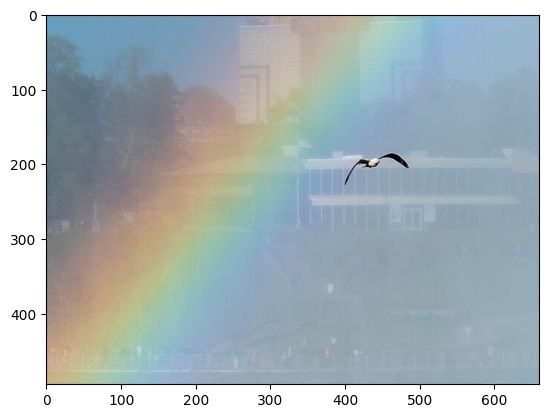

In [7]:

class_names[np.argmax(make_predictions("/content/drive/MyDrive/Project/AI/weather/test/Ring-billed_gull_and_a_rainbow_(52910).jpg"))]

[[[[ -88.939    -103.779    -111.68    ]
   [ -84.939     -99.779    -107.68    ]
   [ -91.939    -106.779    -114.68    ]
   ...
   [ -64.939     -79.779     -94.68    ]
   [ -30.939003  -45.779     -60.68    ]
   [ -77.939     -89.779    -105.68    ]]

  [[ -85.939    -100.779    -108.68    ]
   [ -90.939    -105.779    -113.68    ]
   [ -90.939    -105.779    -113.68    ]
   ...
   [ -75.939     -90.779    -105.68    ]
   [ -47.939003  -62.779     -77.68    ]
   [ -42.939003  -54.779     -70.68    ]]

  [[ -72.939     -87.779     -95.68    ]
   [ -91.939    -106.779    -114.68    ]
   [ -91.939    -106.779    -114.68    ]
   ...
   [ -72.939     -87.779    -102.68    ]
   [ -74.939     -89.779    -104.68    ]
   [ -16.939003  -28.779     -44.68    ]]

  ...

  [[ -78.939     -90.779     -93.68    ]
   [ -81.939     -93.779     -96.68    ]
   [ -67.939     -77.779     -80.68    ]
   ...
   [ -88.939    -103.779    -110.68    ]
   [ -90.939    -105.779    -112.68    ]
   [ -92.939    

'rain'

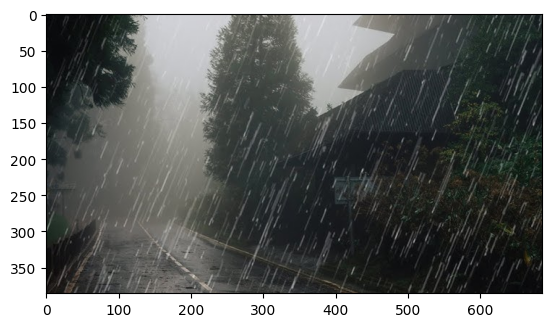

In [8]:
class_names[np.argmax(make_predictions("/content/drive/MyDrive/Project/AI/weather/test/rain.jpeg"))]

[[[[-31.939003  -64.779     -76.68     ]
   [ 45.060997   12.221001    0.3199997]
   [ 66.061      33.221      21.32     ]
   ...
   [ 16.060997  -24.779     -38.68     ]
   [ 75.061      35.221      18.32     ]
   [ 86.061      46.221      29.32     ]]

  [[ 67.061      34.221      22.32     ]
   [ 30.060997   -2.7789993 -14.68     ]
   [ 12.060997  -20.779     -32.68     ]
   ...
   [ 66.061      25.221      11.32     ]
   [ 74.061      34.221      17.32     ]
   [ 88.061      48.221      31.32     ]]

  [[-17.939003  -50.779     -62.68     ]
   [ -9.939003  -42.779     -54.68     ]
   [ 14.060997  -18.779     -30.68     ]
   ...
   [ 47.060997    6.2210007  -7.6800003]
   [ 84.061      44.221      27.32     ]
   [ 86.061      46.221      29.32     ]]

  ...

  [[106.061      64.221      43.32     ]
   [107.061      65.221      44.32     ]
   [110.061      68.221      47.32     ]
   ...
   [ 93.061      48.221      28.32     ]
   [ 89.061      47.221      26.32     ]
   [ 89.061     

'snow'

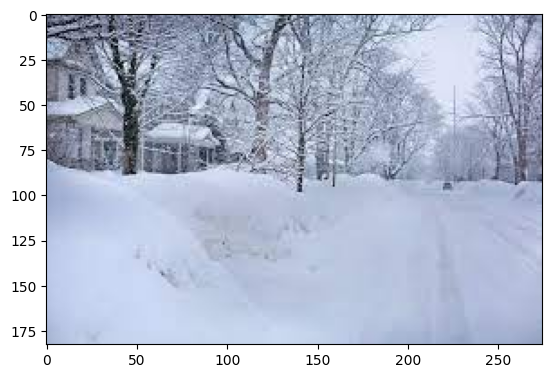

In [9]:
class_names[np.argmax(make_predictions("/content/drive/MyDrive/Project/AI/weather/test/snow.jpeg"))]